In [13]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

def load_data():
    """Lade Daten aus der Datenbank und stelle sicher, dass die Verbindung geschlossen wird."""
    try:
        db = mysql.connector.connect(
            host="localhost",
            user="user",
            password="password",
            port="3306",
            database="realestatepredictor"
        )
        cursor = db.cursor()
        cursor.execute("SELECT * FROM homegate")
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=['id', 'homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])
        return df
    finally:
        cursor.close()
        db.close()

def clean_data(df):
    """Reinige das DataFrame durch das Entfernen von Ausreißern und das Behandeln fehlender Werte."""
    df.dropna(inplace=True)  # Umgang mit fehlenden Werten
    # Entfernen von Ausreißern basierend auf Preis
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['price'] > lower_bound) & (df['price'] < upper_bound)]
    return df

def prepare_data(df):
    """Bereite Daten für das Modellieren vor."""
    input_features = ['latitude', 'longitude', 'rooms', 'floor', 'livingSpace']
    output_feature = 'price'
    X = df[input_features]
    y = df[output_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Beste Parameter: {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Beste Punktzahl (negatives MSE): -119565213120.80363
Mean Squared Error: 103919885992.29637
Root Mean Squared Error: 322366.0745058269
R² Score: 0.5904104083718629
Mean Absolute Error: 185720.5379816319
Mean Absolute Percentage Error: 1.2435500721204344e+20


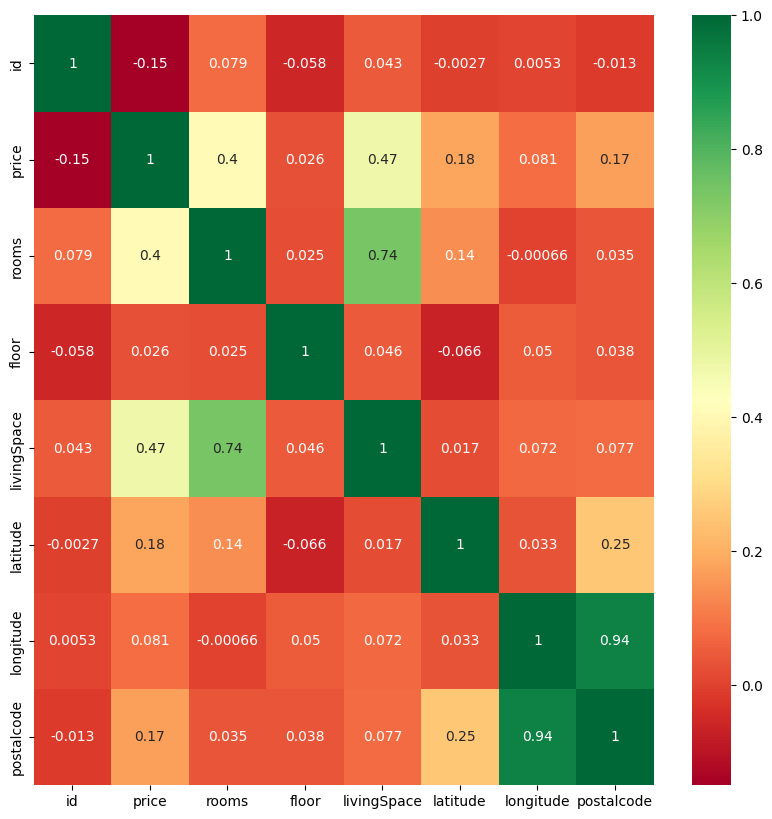

In [14]:
def create_pipeline_and_grid_search(X_train, y_train):
    """Erstelle eine Pipeline und führe eine Gitter-Suche durch."""
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])
    param_grid = {
        'knn__n_neighbors': [3, 5, 7, 10, 15],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

def evaluate_model(grid_search, X_test, y_test):
    """Bewerte das Modell anhand von MSE, RMSE, MAE, MAPE und R²-Metriken."""
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R² Score: {r2}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Absolute Percentage Error: {mape}")

def visualize_correlations(df):
    """Erzeuge eine Korrelation-Heatmap für nur numerische Spalten."""
    numeric_cols = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 10))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap="RdYlGn")
    plt.show()

def main():
    df = load_data()
    df_cleaned = clean_data(df)
    X_train, X_test, y_train, y_test = prepare_data(df_cleaned)
    grid_search = create_pipeline_and_grid_search(X_train, y_train)
    print("Beste Parameter:", grid_search.best_params_)
    print("Beste Punktzahl (negatives MSE):", grid_search.best_score_)
    evaluate_model(grid_search, X_test, y_test)
    visualize_correlations(df_cleaned)

if __name__ == "__main__":
    main()